In [1]:
from enum import Enum
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%run ./weno_mod.ipynb

# Overview

Here we use WENO (first described in [this paper](https://www.sciencedirect.com/science/article/pii/S0021999184711879)) to get high order accurate solutions to the Euler gas equations in a tube (1 space + 1 time dimension). The goal for the implementation is to handle the math cleanly and be relatively efficient.

We'll test to verify that we get 5th order accuracy in space after reconstruction in smooth regions, and then run our solver on a test case that develops shocks to see that we don't produce O(1) oscillations

## Essential Background
We approximately solve the euler gas equations over a 1D interval, which look like a conservation law in a vector $v(x,t)$ with $\partial_t v(x,t) + \partial_x f(v(x,t) = 0$, for $v(x,t) = (r, ru, E)$, with $r(x,t)$ = density, $u(x,t)$ = velocity, $E(x,t)$ = energy density

We'll call the function $f$ the 'physical flux' (details in [ref 2](http://math.tifrbng.res.in/~praveen/notes/acfd2013/euler_1d.pdf)). Following convention, we'll call the variables $(r, ru, E)$ conserved variables, and the variables $(r, u, p)$ primitive variables with $p = p(x,t)$ being pressure ($p$ and $E$ are related by an equation of state).

We'll implement the approach outlined in [ref 1](https://www.sciencedirect.com/science/article/pii/S0021999184711879) which involves cell averages. Here, the interval is divided into small intervals called cells. Integrating the PDE over each cell results in new system of equations with only time derivatives of cell averages of $v(x,t)$ and fluxes $f(v(x,t)$ at cell interfaces.

WENO approximates $v(x,t)$ at cell interfaces using only cell averages to high order accuracy in smooth regions. Using these estimates and the integrated version of the PDE, we'll evolve cell averages in time and turn those final cell averages into high order accurate point values in both time and space. Near shocks the method provably does not produce large oscillations. Internally, the approximation uses a weighted combination of derivatives of interpolants to cell averages over small contiguous regions called stencils. The weights are chosen so that combined accuracy over smaller stencils matches interpolation over the larger stencil made by their union, but shocks decrease a stencil's contribution to control oscillation. This is possible because weights contain a sobolev-norm-like factor that grows large when an interpolant is not smooth. Rigorous details are in [ref 3](https://www.sciencedirect.com/science/article/pii/S0021999196901308).

## Implementation

The code below implements the solver, which repeatedly reconstructs two values at each interface from averages using weno, combines these estimates with a monotone flux, calculates flux differences, and takes one time step until we reach integration time.

The version of weno that we actually use is an improvement of the original and described in [ref 4](https://www.sciencedirect.com/science/article/pii/S0021999107005232). This function is contained in weno_mod.ipynb. Reconstruction is carried out in local characteristic variables as advised in [ref 5](https://www.cambridge.org/core/journals/acta-numerica/article/abs/essentially-nonoscillatory-and-weighted-essentially-nonoscillatory-schemes/28F4F341659059051F12A4CC7924905C) for robustness. Here we'll support periodic and neumann boundary conditions. For neumann conditions, we use high order difference formulas from [ref 6](https://www.cambridge.org/core/journals/mathematical-gazette/article/formulae-for-numerical-differentiation/95CEECC126F4672B8EA37E711B9E1D9F). 

In [2]:
class BCType(Enum):
    PERIODIC = 0
    NEUMANN = 1

In [3]:
class GasSolver:
    #inputs: a vector of initial cell averages, boundary condition type, adiabatic constant of the gas
    def __init__(self, cell_avgs_init, bc_type, gamma):
        self.cell_avgs_init = np.copy(cell_avgs_init)
        self.bc_type = bc_type
        self.gamma = gamma
        self.order = 5
        
    # input: a tuple of conserved vars (r, ru, E)
    # returns primitive variables: r(density), u (velocity), p (pressure), e (energy density)
    def get_prim_vars(self, cons_vars):
        rho = cons_vars[0] #density
        rho_u = cons_vars[1] #density*velocity
        energy_density = cons_vars[2] #energy per unit volume
        vel = rho_u/rho #velocity
        pressure = (self.gamma - 1)*(energy_density - 0.5*rho*vel**2) #caloric equation of state
        sound_speed = (self.gamma*pressure/rho)**0.5 #speed of sound in the medium
        return rho,vel,pressure,energy_density,sound_speed

    # applies flux function to an input vector of conserved variables
    def physical_flux(self, cons_var_vec):
        rho_vec = cons_var_vec[0,:]
        rho_u_vec = cons_var_vec[1,:] 
        energy_density_vec = cons_var_vec[2,:]
        vel_vec = np.multiply(rho_u_vec,rho_vec**-1.0)
        pressure_vec = (self.gamma - 1)*(energy_density_vec - 0.5*np.multiply(rho_vec,vel_vec**2))
        #returning F(r,ru,e)
        f_cons = np.zeros((3,cons_var_vec.shape[1]),dtype=np.float64)
        f_cons[0,:] = rho_u_vec
        f_cons[1,:] = pressure_vec + rho_vec*vel_vec**2
        f_cons[2,:] = np.multiply(energy_density_vec + pressure_vec, vel_vec)
        return f_cons
    
    # undoes characteristic transform
    # diagonalizes jacobian of physical flux (above)
    # closed form from ref 2 (above)
    def char_to_cons(self, cons_vars):
        rho, vel, pressure, energy_density, sound_speed = self.get_prim_vars(cons_vars)
        enthalpy = (energy_density + pressure)/rho
        
        char_to_cons = np.zeros((3,3),dtype=np.float64)
        char_to_cons[0] = np.array([1.0,1.0,1.0])
        char_to_cons[1] = np.array([vel - sound_speed,vel,vel + sound_speed])
        char_to_cons[2] = np.array([enthalpy - vel*sound_speed, 0.5*vel**2, enthalpy + vel*sound_speed])
        return char_to_cons

    # applies characteristic transform
    # written explicitly for efficiency (not inverting char_to_cons)
    # closed form also from ref 2 (above)
    def cons_to_chars(self, cons_vars):
        rho, vel, pressure, energy_density, sound_speed = self.get_prim_vars(cons_vars)
        #precomputing for simpler expressions
        a_inv = 1/sound_speed
        a_inv_sq = a_inv/sound_speed
        vel_to_sound = vel/sound_speed
        gam_a_inv_sq = 0.5*(self.gamma - 1)*a_inv_sq
    
        cons_to_char = np.zeros((3,3),dtype=np.float64)
        cons_to_char[0] = np.array([gam_a_inv_sq*vel*vel*0.5 + 0.5*vel_to_sound, -gam_a_inv_sq*vel - 0.5*a_inv, gam_a_inv_sq])
        cons_to_char[1] = np.array([1.0 - gam_a_inv_sq*vel*vel, gam_a_inv_sq*2*vel, -gam_a_inv_sq*2])
        cons_to_char[2] = np.array([gam_a_inv_sq*vel*vel*0.5 - 0.5*vel_to_sound, -gam_a_inv_sq*vel + 0.5*a_inv, gam_a_inv_sq])
        return cons_to_char

    # fills in boundary values from interior left and right estimates, char speeds
    # uses bickley's coeffs from ref 6 (above) to enforce derivatives being zero
    def handle_neumann_bcs(self, left_ests, right_ests, char_speeds):
        bickley_coeffs = [-50, 96, -72, 32, -6]
        n = self.cell_avgs_init.shape[1]
        half_stencil_size = (self.order - 1)//2
        #handle left and right ends separately
        for est_vec in [left_ests, right_ests]:
            for on_left_end in [True, False]:
                spacing = half_stencil_size
                on_right_end = not on_left_end
                if (on_left_end and est_vec is left_ests) or (on_right_end and est_vec is right_ests):
                    spacing = spacing + 1
                edge_idx = 0 if on_left_end else n
                if on_right_end:
                    spacing = -spacing
                #compute edge from neumann condition (left or right end of the tube)
                diff_points = np.arange(edge_idx + spacing, edge_idx + self.order*spacing, spacing)
                est_vec[:,edge_idx] = est_vec[:,diff_points]@bickley_coeffs[1:] * -1/bickley_coeffs[0]
                #fill in intermediate values from edge + neumann condition
                while spacing != 0:
                    spacing = spacing + (-1 if on_left_end else 1)
                    if spacing == 0:
                        break
                    diff_points = np.arange(edge_idx + 2*spacing, edge_idx + self.order*spacing, spacing)
                    est_vec[:,edge_idx + spacing] = (est_vec[:,edge_idx]*bickley_coeffs[0] + \
                                                     est_vec[:, diff_points]@ \
                                                     bickley_coeffs[2:])* -1/bickley_coeffs[1]
            char_speeds[0:half_stencil_size] = np.max(char_speeds)
            char_speeds[n+1 - half_stencil_size:n+1] = char_speeds[0]

    # computes left and right values using weno by projecting into characteristics near the interface
    # returns estimates and max characteristic speeds at each interface
    def reconstruct(self,cell_avgs):
        n = self.cell_avgs_init.shape[1]
        dims = self.cell_avgs_init.shape[0]
        left_ests = np.zeros((dims,n+1),dtype=np.float64)
        right_ests = np.zeros((dims,n+1),dtype=np.float64)
        char_speeds = np.zeros(n+1,dtype=np.float64)
        half_stencil_size = (self.order - 1)//2
        interf_avgs = (np.roll(cell_avgs, -1, axis=1) + cell_avgs)/2
        for i in range(n + 1):
            # include all cells involved in either of two stencils at the interface
            leftmost_cell = i - half_stencil_size - 1
            rightmost_cell = i + half_stencil_size
            
            if self.bc_type == BCType.NEUMANN:
                if i < half_stencil_size or n - i < half_stencil_size:
                    # these interfaces are not endpoints of any stencil centers
                    # we'll construct these out of the other values at the end
                    continue
                leftmost_cell = max(0,leftmost_cell)
                rightmost_cell = min(n-1, rightmost_cell)
                
            stencil_ids = np.array(range(leftmost_cell, rightmost_cell+1))
            if self.bc_type == BCType.PERIODIC:
                stencil_ids = stencil_ids % n
                
            #choosing a basis for local characteristic decomposition
            interf_avg = interf_avgs[:,i-1] if i > 0 else (cell_avgs[:,0] + cell_avgs[:,n-1])/2
            to_cons = self.char_to_cons(interf_avg)
            to_chars = self.cons_to_chars(interf_avg)
            
            #converting to characteristics
            char_vars = to_chars @ cell_avgs[:,stencil_ids]
            if not(self.bc_type == BCType.NEUMANN and i == half_stencil_size):
                char_left_est = weno5(char_vars[:,0], char_vars[:,1],char_vars[:,2], char_vars[:,3], char_vars[:,4])
                #back to conserved variables
                left_ests[:,i] = to_cons @ char_left_est
            if not(self.bc_type == BCType.NEUMANN and n-i == half_stencil_size):
                char_right_est = weno5(char_vars[:,-1], char_vars[:,-2], char_vars[:,-3], char_vars[:,-4], char_vars[:,-5])
                right_ests[:,i] = to_cons @ char_right_est
        
            #characteristic speeds at the point are u-a, u, u + a, u = velocity, a = sound speed
            #the max of these speeds is needed for the lax-friedrichs function later
            _, left_u, _ , _ , left_a = self.get_prim_vars(interf_avg)
            char_speeds[i] = np.max(np.abs([left_u - left_a, left_u + left_a]))

        #neumann boundary conditions
        if self.bc_type == BCType.NEUMANN:
            self.handle_neumann_bcs(left_ests, right_ests, char_speeds)

        return left_ests, right_ests, char_speeds

    #computes approximate fluxes at each interface and returns the largest char speed
    def monotone_flux_and_eigval(self, cell_avgs):
        left_ests, right_ests, char_speeds = self.reconstruct(cell_avgs)
        f_left = self.physical_flux(left_ests)
        f_right = self.physical_flux(right_ests)
        diffs = np.multiply(char_speeds,right_ests - left_ests)
        #local lax-friedrichs at every interface
        apx_fluxes = (f_left + f_right - diffs)/2
        return apx_fluxes, np.max(char_speeds)

    #returns difference of the lax friedrichs function 
    #over each cell and max characteristic speed
    def flux_diffs_and_speed(self, cell_avgs):
        dx = 1.0/cell_avgs.shape[1]
        apx_fluxes, max_speed = self.monotone_flux_and_eigval(cell_avgs)
        flux_diffs = -1.0*(apx_fluxes[:,1:] - apx_fluxes[:,0:-1])/dx
        return flux_diffs, max_speed

    #4th order accurate RK method from ref 1
    def solve(self, int_time):
        t = 0
        v = self.cell_avgs_init
        cfl = 0.6 #cfl no.
        dx = 1.0/(v.shape[1]) #grid spacing
        while t < int_time:
            #takes one step of the RK method
            l_0, max_char_speed = self.flux_diffs_and_speed(v)
            dt = min(cfl*dx/max_char_speed, int_time - t)
            v_1 = v + 0.5*dt*l_0
            l_1, _ = self.flux_diffs_and_speed(v_1)
            v_2 = 0.5*v + 0.5*v_1 - 0.25*dt*l_0 + 0.5*dt*l_1
            l_2, _ = self.flux_diffs_and_speed(v_2)
            v_3 = v/9 + 2*v_1/9 + 2*v_2/3 - dt*l_0/9 - dt*l_1/3 + dt*l_2
            l_3, _ = self.flux_diffs_and_speed(v_3)
            v = v_1/3 + v_2/3 + v_3/3 + dt*l_1/6 + dt*l_3/6
            t = t + dt
        return v

## Accuracy tests

First we'll test that our solution achieves fifth order accuracy in space (in smooth regions), and that combining it with our fourth order time method also gives us at least fourth order accuracy overall. We'll choose initial conditions such that corresponding analytic solutions are smooth everywhere. So we let initial density be distributed as $1 + \frac{1}{4}\sin(4\pi x)$ over the tube, with velocity and pressure uniform everywhere (1 unit). With periodic bcs, the solution for density is periodic in time (as in advection), and we test against expected results after half a period.

In [4]:
# computes initial cell averages for
# velocity = pressure = 1 everywhere, and
# density = 1 + 0.25*sin(4pi*x) initially
def make_periodic_ics(n, gamma):
    avg_cons_vars = np.zeros((3,n),dtype=np.float64)
    dx = 1.0/n
    avg_cons_vars[0] = 1.0 + (np.sin(2*np.pi*dx)/(8*np.pi*dx))*np.sin(4*np.pi*np.linspace(0,1,n,endpoint=False)+2*dx*np.pi)
    avg_cons_vars[1] = avg_cons_vars[0]
    avg_cons_vars[2] = 1.0/(gamma-1) + 0.5*avg_cons_vars[0]
    return avg_cons_vars

### Accuracy in space

We run a single iteration of reconstruction (without time evolution) from cell averages for six successively smaller grid spacings, each smaller by a factor of two. 

The infinity norm error falls by a factor of ~32 each time, indicating fifth order accuracy! We also graph a log-log plot of error against grid spacing to see visually that the slope is ~5, i.e., that observed error looks parallel to an order-5 line. (Spacings are chosen so that error is far from machine epsilon)

Error ratios: [32.05771763649837, 31.976947821348872, 31.990292674540093, 31.971670190274843, 31.11842105263158]


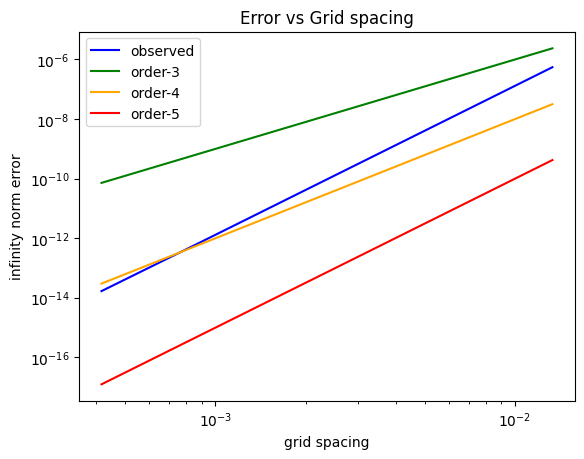

In [5]:
errs_inf = []
dxs = []

def plot_order(errs_inf, dxs):
    print("Error ratios: " + str([errs_inf[i]/errs_inf[i+1] for i in range(len(errs_inf) - 1)]))
    plt.loglog(dxs,errs_inf, label="observed",color="blue")
    plt.loglog(dxs,np.array(dxs)**3,label="order-3",color="green")
    plt.loglog(dxs,np.array(dxs)**4,label="order-4",color="orange")
    plt.loglog(dxs,np.array(dxs)**5,label="order-5",color="red")
    plt.legend()
    plt.xlabel("grid spacing")
    plt.ylabel("infinity norm error")
    plt.title("Error vs Grid spacing")
    plt.show()

n = 75 #no of cells
gamma = 1.4 #adiabatic constant

for i in range(6):
    p_ics = make_periodic_ics(n, gamma)
    adv_solver = GasSolver(p_ics, BCType.PERIODIC, gamma)
    #uses left estimates at each interface
    apx_cons_vars,_,_ = adv_solver.reconstruct(p_ics)
    #analytic solution for density (at t = 0s):
    rho_expected = 1 + (1/4)*np.sin(4*np.pi*np.linspace(0,1,num=n+1,endpoint=True))
    #compute error
    errs_inf.append(la.norm(apx_cons_vars[0,:] - rho_expected, np.inf))
    dxs.append(1.0/n)
    n = n*2

plot_order(errs_inf, dxs)

### Accuracy with time evolution

Now we evolve our solver to t = 0.25s on three successively finer grids (each smaller again by a factor of 2). This is half the period of the analytic solution, so the density we should see is $1 - \frac{1}{4}\sin (4 \pi x)$. Comparing against this on each grid, we expect at least fourth order accuracy overall because our time steps are on the order of the grid spacing. Remarkably we actually see fifth order accuracy overall again because the constants for the time error are small.

Solving with interval divided into 50 cells (1/3)
Solving with interval divided into 100 cells (2/3)
Solving with interval divided into 200 cells (3/3)
Error ratios: [34.966341698439656, 33.09395486076146]


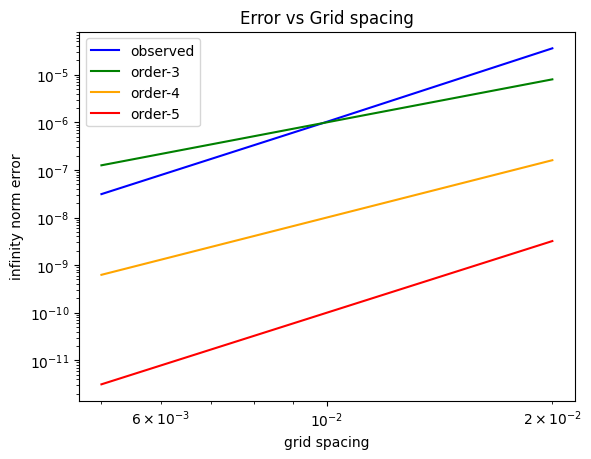

In [6]:
errs_inf = []
dxs = []
gamma = 1.4 #adiabatic constant
n = 50 #no of cells
int_time = 0.25 #seconds

num_iters = 3
for i in range(num_iters):
    p_ics = make_periodic_ics(n, gamma)
    print("Solving with interval divided into " + str(n) + " cells (" + str(i+1) +"/" + str(num_iters)+")")
    
    adv_solver = GasSolver(p_ics, BCType.PERIODIC, gamma)
    #solution with time evolution
    sol = adv_solver.solve(int_time)
    #reconstruct interface values
    apx_cons_vars, _, _ = adv_solver.reconstruct(sol)
    #analytic solution for density at t=0.25:
    rho_expected = 1 - 0.25*np.sin(4*np.pi*np.linspace(0,1,num=n+1,endpoint=True))
    #compute errors
    errs_inf.append(la.norm(apx_cons_vars[0,:] - rho_expected, np.inf))
    dxs.append(1.0/n)
    n = n*2

plot_order(errs_inf, dxs)

## Behavior with shocks

We'll sanity check behavior on shocks with the sod problem. Initial conditions consist of two regions of uniform pressure and density separated by a barrier, with neumann BCs. We integrate until t = 0.2 s at which point shocks are present. Exact solutions (with the same initial conditions chosen here) and an approximation by a different method are shown in this [link](https://help.sim-flow.com/validation/sod-shock#_results). The approximation there displays visible "gibbs-like" phenomena at discontinuities (in the velocity, for instance, at t = 0.2 between x = 0.8 and 0.9). Our solution, however, has no such phenomena, as we see in our final plots. (This takes ~15s on a typical laptop)

In [7]:
def make_sod_ics(n, gamma):
    avg_cons_vars = np.zeros((3,n),dtype=np.float64)
    points = np.linspace(0,1,n)
    #two constant pressure and density regions separated by a barrier at x = 0.5
    avg_cons_vars[0] = np.array([0.125 if p > 0.5 else 1.0 for p in points])
    avg_cons_vars[2] = np.array([0.1 if p > 0.5 else 1.0 for p in points])*1.0/(gamma - 1)
    return avg_cons_vars

Running solver...
Done!


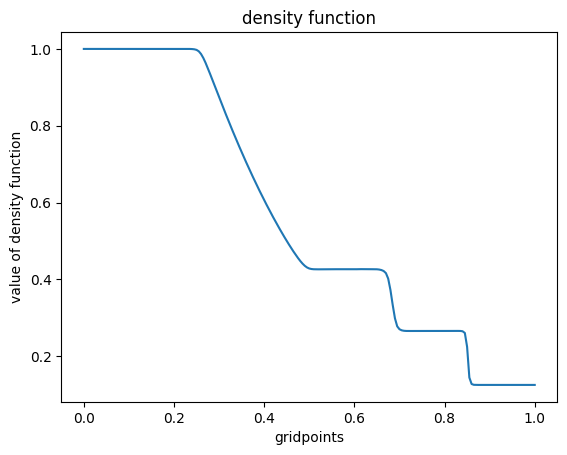

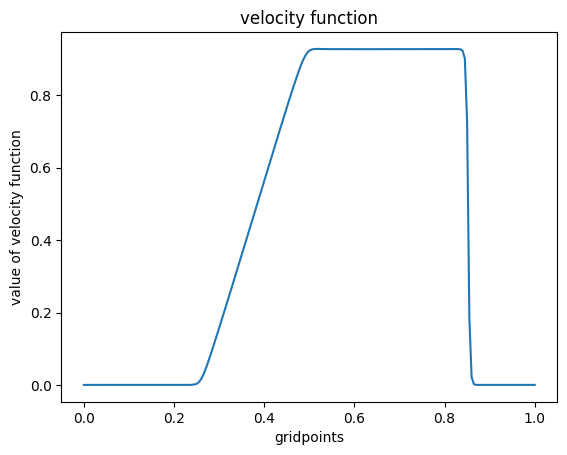

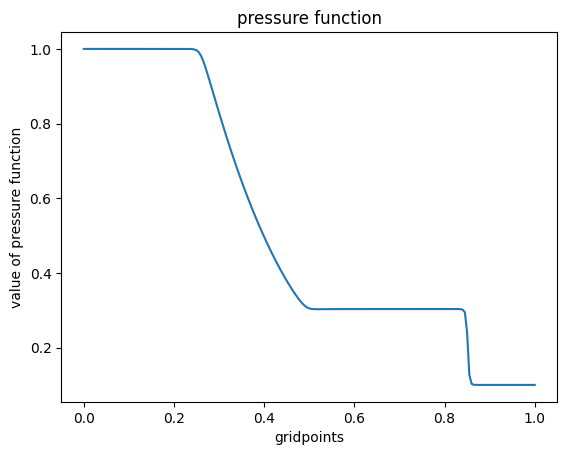

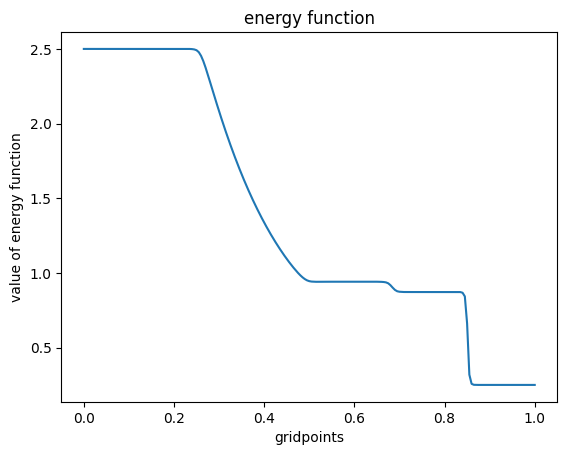

In [8]:
n = 200

def plot(vs, data, xlabel, ylabel, title):
    plt.figure()
    plt.plot(vs,data)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

gamma = 1.4
int_time = 0.2
sod_ics = make_sod_ics(n, gamma)
sod_solver = GasSolver(sod_ics, BCType.NEUMANN, gamma)
print("Running solver...")
sol = sod_solver.solve(int_time)
print("Done!")

apx_cons_vars, _, _ = sod_solver.reconstruct(sol)
rho_vec = apx_cons_vars[0,:]
rho_u_vec = apx_cons_vars[1,:] 
vel_vec = np.multiply(rho_u_vec,rho_vec**-1.0) #velocity
energy_density_vec = apx_cons_vars[2,:]
pressure_vec = (gamma - 1)*(energy_density_vec - 0.5*np.multiply(rho_vec,vel_vec**2))

#interface coords
points = np.linspace(0,1,n+1,endpoint=True)

plot(points,rho_vec,"gridpoints","value of density function","density function")

plot(points,vel_vec,"gridpoints","value of velocity function","velocity function")

plot(points,pressure_vec,"gridpoints","value of pressure function","pressure function")

plot(points,energy_density_vec,"gridpoints","value of energy function","energy function")